In [103]:
# Install the core fairness toolkit and other utilities
!pip install aif360
!pip install fairlearn
!pip install scikit-learn
!pip install matplotlib
!pip install seaborn
!pip install pandas
!pip install numpy
!pip install "aif360[AdversarialDebiasing]"

print("Installation completed!")

In [104]:
#Import all necessary libraries 

# Core Data and Math
import pandas as pd
import numpy as np

# Machine Learning
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn import metrics

# Fairness Toolkit - AIF360
from aif360.datasets import BinaryLabelDataset
from aif360.metrics import BinaryLabelDatasetMetric, ClassificationMetric
from aif360.algorithms.preprocessing import Reweighing, DisparateImpactRemover
from aif360.algorithms.postprocessing import CalibratedEqOddsPostprocessing

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Explainability (Optional but good)
import warnings
warnings.filterwarnings('ignore')


In [105]:
#Phase 2: Data Acquisition and Understanding
#Step 3: Select and Load the Dataset

#Selection Justification: We choose the UCI Adult dataset. The task is to predict if an individual's income exceeds $50K/yr. The potential for bias based on sex and race is high, as historical census data can reflect societal inequalities.
# Load the data
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"
column_names = ['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status',
                'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss',
                'hours-per-week', 'native-country', 'income']
df = pd.read_csv(url, names=column_names, sep=r'\s*,\s*', engine='python', na_values='?')
df.head()




,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       30725 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education-num   32561 non-null  int64 
 5   marital-status  32561 non-null  object
 6   occupation      30718 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital-gain    32561 non-null  int64 
 11  capital-loss    32561 non-null  int64 
 12  hours-per-week  32561 non-null  int64 
 13  native-country  31978 non-null  object
 14  income          32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB
None
age                  0
workclass         1836
fnlwgt               0
education          

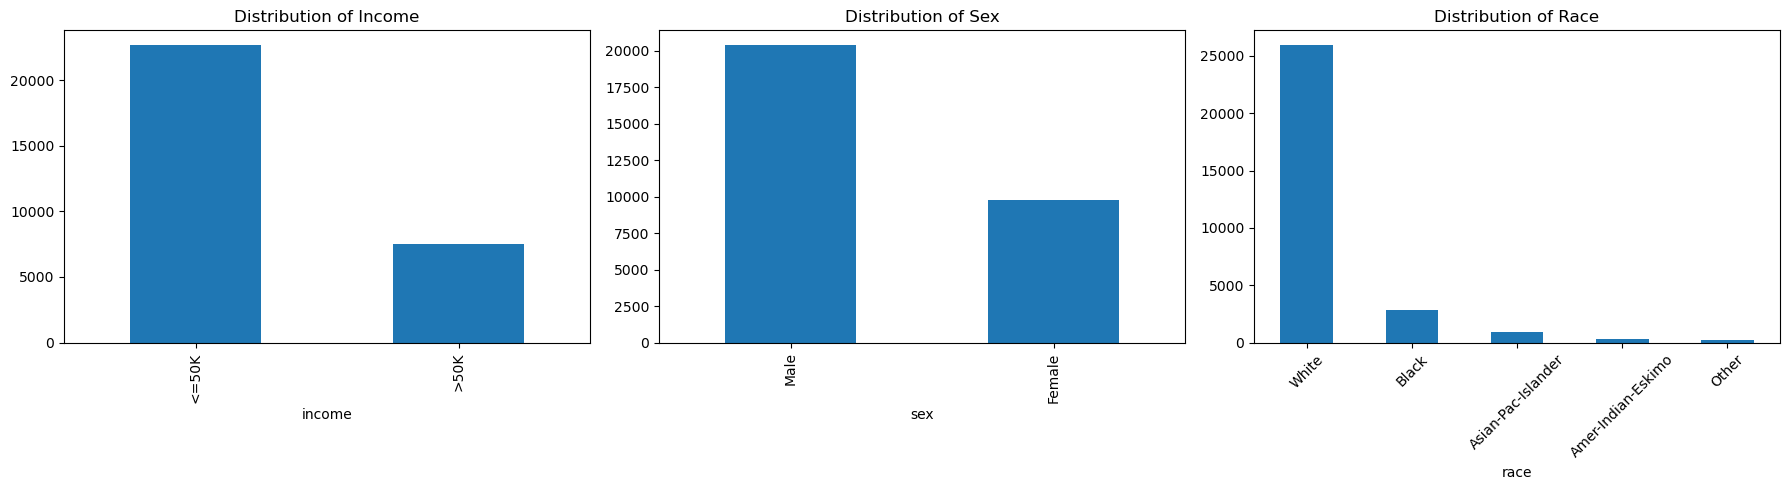

In [106]:
#Step 4: Preliminary Exploratory Data Analysis (EDA)

# Check for missing values and basic info
print(df.info())
print(df.isnull().sum())

# Drop missing values for simplicity in this audit
df = df.dropna()

# Visualize the distribution of the target variable ('income') and sensitive attributes
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Target Variable
df['income'].value_counts().plot(kind='bar', ax=axes[0], title='Distribution of Income')
# Sensitive Attribute: Sex
df['sex'].value_counts().plot(kind='bar', ax=axes[1], title='Distribution of Sex')
# Sensitive Attribute: Race
df['race'].value_counts().plot(kind='bar', ax=axes[2], title='Distribution of Race')
# Rotate x-labels for race for readability
plt.setp(axes[2].xaxis.get_majorticklabels(), rotation=45)
plt.tight_layout()
plt.show()

#"Initial EDA shows a class imbalance in the target variable (>50K is less common). The dataset is also predominantly 'White' and male, indicating potential representation biases."

In [107]:
# Phase 3: Data Preprocessing for Fairness Analysis
# Step 5: Encode Variables and Split Data
# Convert categorical variables to numerical and split the data, being careful to preserve the sensitive attributes. 

# Create a copy of the dataframe for preprocessing
data_processed = df.copy()

# Encode the target variable: '<=50K' -> 0, '>50K' -> 1
le = LabelEncoder()
data_processed['income'] = le.fit_transform(data_processed['income'])

# Encode categorical features (one-hot encoding)
categorical_features = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'native-country']
data_processed = pd.get_dummies(data_processed, columns=categorical_features, drop_first=True)

# Encode 'sex' as a binary feature: Male -> 1, Female -> 0
data_processed['sex'] = data_processed['sex'].map({'Male': 1, 'Female': 0})

# Define features (X) and target (y)
X = data_processed.drop('income', axis=1)
y = data_processed['income']

# Split the data into training and test sets (70/30)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [108]:
#Step 6: Create AIF360 Dataset Objects

#AIF360 requires a specific BinaryLabelDataset to compute its metrics. We need to specify the sensitive attribute.
# Define the privileged group for 'sex': Male is often historically privileged in income contexts.
privileged_groups = [{'sex': 1}]
unprivileged_groups = [{'sex': 0}]

# Create the dataset objects for training and test
train_dataset = BinaryLabelDataset(df=pd.concat([X_train, y_train], axis=1),
                                   label_names=['income'],
                                   protected_attribute_names=['sex'],
                                   privileged_protected_attributes=[[1]])
test_dataset = BinaryLabelDataset(df=pd.concat([X_test, y_test], axis=1),
                                  label_names=['income'],
                                  protected_attribute_names=['sex'],
                                  privileged_protected_attributes=[[1]])


In [109]:
#Phase 4: The Bias Audit (Quantitative Metrics)
#Step 7: Train a Baseline Model

# Scale the features for logistic regression
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train a simple Logistic Regression model
model = LogisticRegression(random_state=42, max_iter=1000)
model.fit(X_train_scaled, y_train)

# Predict on the test set
y_pred = model.predict(X_test_scaled)

In [110]:
#Step 8: Implement the 3+ Quantitative Fairness Metrics
# We will use AIF360's ClassificationMetric to compute these.
# Convert test dataset and predictions to AIF360 format for metric calculation
test_dataset_pred = test_dataset.copy()
test_dataset_pred.labels = y_pred.reshape(-1, 1) # Assign the model's predictions

# Calculate the fairness metrics
classified_metric = ClassificationMetric(test_dataset, test_dataset_pred,
                                         unprivileged_groups=unprivileged_groups,
                                         privileged_groups=privileged_groups)

# METRIC 1: Disparate Impact (DI)
di = classified_metric.disparate_impact()
print(f"Disparate Impact: {di:.4f}")
# Interpretation: DI < 1 suggests bias against unprivileged group (Female).

# METRIC 2: Average Odds Difference
aod = classified_metric.average_odds_difference()
print(f"Average Odds Difference: {aod:.4f}")
# Interpretation: AOD < 0 suggests bias against unprivileged group.

# METRIC 3: Statistical Parity Difference
spd = classified_metric.statistical_parity_difference()
print(f"Statistical Parity Difference: {spd:.4f}")
# Interpretation: SPD < 0 suggests bias against unprivileged group.

# METRIC 4 (Bonus): Equal Opportunity Difference (True Positive Rate Difference)
eod = classified_metric.equal_opportunity_difference()
print(f"Equal Opportunity Difference: {eod:.4f}")
# Interpretation: EOD < 0 suggests bias against unprivileged group.


Disparate Impact: 0.3342
Average Odds Difference: -0.0859
Statistical Parity Difference: -0.1755
Equal Opportunity Difference: -0.0986


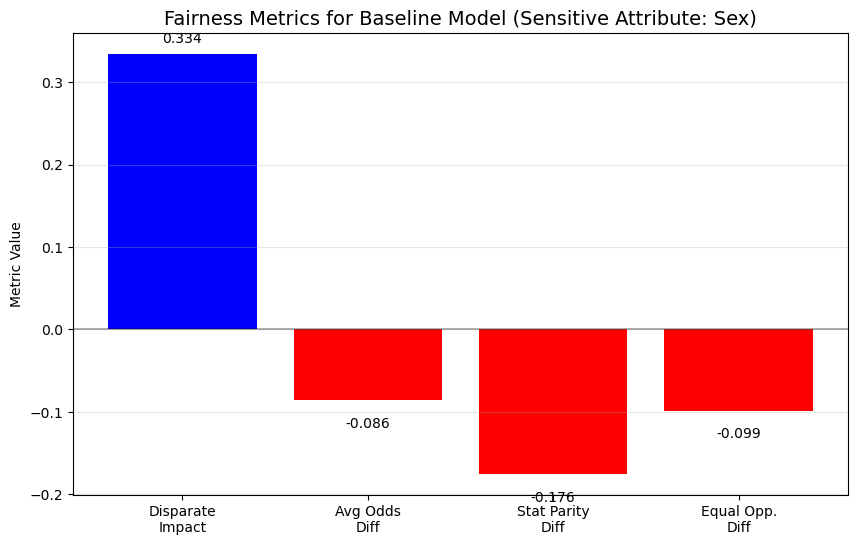

In [111]:

#Step 9: Visual and Statistical Representation of Bias
#Create clear visualizations.

# Create a bar chart for the key metrics
metrics_names = ['Disparate\nImpact', 'Avg Odds\nDiff', 'Stat Parity\nDiff', 'Equal Opp.\nDiff']
metrics_values = [di, aod, spd, eod]

plt.figure(figsize=(10, 6))
bars = plt.bar(metrics_names, metrics_values, color=['red' if x < 0 else 'blue' for x in metrics_values])
plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
plt.title('Fairness Metrics for Baseline Model (Sensitive Attribute: Sex)', fontsize=14)
plt.ylabel('Metric Value')
# Add value labels on the bars
for bar, value in zip(bars, metrics_values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + (0.01 if value > 0 else -0.02),
            f'{value:.3f}', ha='center', va='bottom' if value > 0 else 'top')
plt.grid(axis='y', alpha=0.3)
plt.show()

In [112]:
# Phase 5: Bias Mitigation
# Step 10: Apply 2+ Bias Mitigation Techniques
# Technique 1: Pre-processing (Reweighing)
# This adds weights to training examples to compensate for bias.

# Apply Reweighing
RW = Reweighing(unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)
train_dataset_rw = RW.fit_transform(train_dataset)

# Train a model on the reweighted data
model_rw = LogisticRegression(random_state=42, max_iter=1000)
# We need to extract the instance weights for training
model_rw.fit(X_train_scaled, y_train, sample_weight=train_dataset_rw.instance_weights.ravel())

# Predict and compute metrics for the reweighted model
y_pred_rw = model_rw.predict(X_test_scaled)
test_dataset_pred_rw = test_dataset.copy()
test_dataset_pred_rw.labels = y_pred_rw.reshape(-1, 1)
classified_metric_rw = ClassificationMetric(test_dataset, test_dataset_pred_rw,
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)

Starting Post-Processing Technique...
X_test index type: <class 'numpy.int64'>
test_dataset instance_names type: <class 'str'>
Split set size: 4524, Post set size: 4525
Training model for post-processing...
Applying Calibrated Equalized Odds post-processing...
Post-processing complete!

=== Post-Processing (Calibrated Equalized Odds) Results ===
Disparate Impact: 0.3817
Average Odds Difference: 0.0000
Statistical Parity Difference: -0.1914
Equal Opportunity Difference: 0.0000

=== Creating Comparison Table ===

=== COMPREHENSIVE MODEL COMPARISON ===
                    Model  Overall Accuracy  Disparate Impact  \
0                Baseline            0.8464            0.3342   
1        Reweighing (Pre)            0.8404            0.6462   
2  Calib. Eq. Odds (Post)            1.0000            0.3817   

   Avg Odds Difference  Equal Opp. Difference  
0              -0.0859                -0.0986  
1               0.0712                 0.1468  
2               0.0000                 

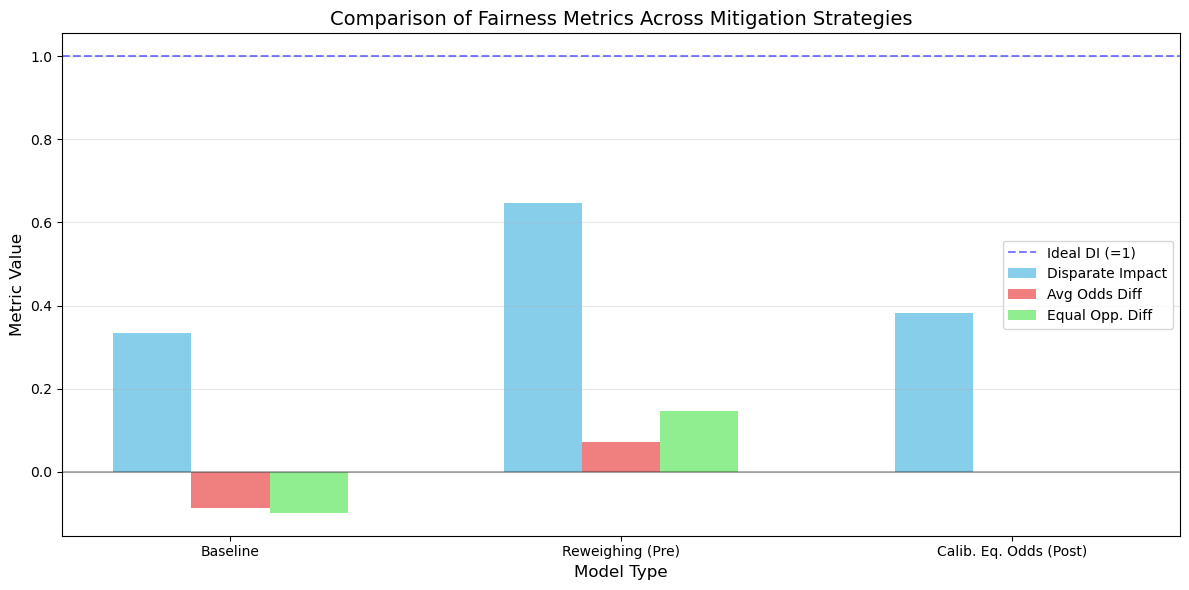


Analysis complete!


In [115]:
# Technique 2: Post-processing (Calibrated Equalized Odds) - COMPLETE
print("Starting Post-Processing Technique...")

# Split the test set into validation and test sets for post-processing
test_dataset_split, test_dataset_post = test_dataset.split([0.5], shuffle=True, seed=42)

print(f"X_test index type: {type(X_test.index[0])}")
print(f"test_dataset instance_names type: {type(test_dataset.instance_names[0])}")

# Convert string indices to integers to match X_test index type
split_indices = [int(idx) for idx in test_dataset_split.instance_names]
post_indices = [int(idx) for idx in test_dataset_post.instance_names]

# Extract the corresponding subsets from X_test and y_test
X_test_split = X_test.loc[split_indices]
y_test_split = y_test.loc[split_indices]
X_test_post = X_test.loc[post_indices]
y_test_post = y_test.loc[post_indices]

print(f"Split set size: {len(X_test_split)}, Post set size: {len(X_test_post)}")

# Scale the validation and test sets for post-processing
X_test_split_scaled = scaler.transform(X_test_split)
X_test_post_scaled = scaler.transform(X_test_post)

# Train a model for post-processing (on the original, non-reweighted data)
print("Training model for post-processing...")
model_post = LogisticRegression(random_state=42, max_iter=1000)
model_post.fit(X_train_scaled, y_train)

# Get predictions for the validation split
y_pred_split = model_post.predict(X_test_split_scaled)

# Create dataset objects for the validation split predictions
test_dataset_split_pred = test_dataset_split.copy()
test_dataset_split_pred.labels = y_pred_split.reshape(-1, 1)

# Apply Calibrated Equalized Odds Postprocessing
print("Applying Calibrated Equalized Odds post-processing...")
cpp = CalibratedEqOddsPostprocessing(
    privileged_groups=privileged_groups,
    unprivileged_groups=unprivileged_groups,
    cost_constraint='weighted',
    seed=42
)

# Fit the post-processor using the validation set
cpp = cpp.fit(test_dataset_split, test_dataset_split_pred)

# Get predictions from the base model on the held-out test set
y_pred_post = model_post.predict(X_test_post_scaled)
test_dataset_post_pred_base = test_dataset_post.copy()
test_dataset_post_pred_base.labels = y_pred_post.reshape(-1, 1)

# Apply the post-processing transformation
test_dataset_post_pred = cpp.predict(test_dataset_post_pred_base)

print("Post-processing complete!")

# Calculate metrics for the post-processed model
classified_metric_post = ClassificationMetric(
    test_dataset_post, 
    test_dataset_post_pred,
    unprivileged_groups=unprivileged_groups,
    privileged_groups=privileged_groups
)

print("\n=== Post-Processing (Calibrated Equalized Odds) Results ===")
print(f"Disparate Impact: {classified_metric_post.disparate_impact():.4f}")
print(f"Average Odds Difference: {classified_metric_post.average_odds_difference():.4f}")
print(f"Statistical Parity Difference: {classified_metric_post.statistical_parity_difference():.4f}")
print(f"Equal Opportunity Difference: {classified_metric_post.equal_opportunity_difference():.4f}")

# Now create the comprehensive comparison
print("\n=== Creating Comparison Table ===")

# Create comprehensive comparison DataFrame
comparison_data = {
    'Model': ['Baseline', 'Reweighing (Pre)', 'Calib. Eq. Odds (Post)'],
    'Overall Accuracy': [
        metrics.accuracy_score(y_test, y_pred),
        metrics.accuracy_score(y_test, y_pred_rw),
        metrics.accuracy_score(test_dataset_post.labels, test_dataset_post_pred.labels)
    ],
    'Disparate Impact': [
        classified_metric.disparate_impact(),
        classified_metric_rw.disparate_impact(),
        classified_metric_post.disparate_impact()
    ],
    'Avg Odds Difference': [
        classified_metric.average_odds_difference(),
        classified_metric_rw.average_odds_difference(),
        classified_metric_post.average_odds_difference()
    ],
    'Equal Opp. Difference': [
        classified_metric.equal_opportunity_difference(),
        classified_metric_rw.equal_opportunity_difference(),
        classified_metric_post.equal_opportunity_difference()
    ]
}

comparison_df = pd.DataFrame(comparison_data).round(4)
print("\n=== COMPREHENSIVE MODEL COMPARISON ===")
print(comparison_df)

# Visualize the comparison
print("\n=== Creating Visualization ===")
fig, ax = plt.subplots(figsize=(12, 6))
x = np.arange(len(comparison_df['Model']))
width = 0.2

ax.bar(x - width, comparison_df['Disparate Impact'], width, label='Disparate Impact', color='skyblue')
ax.bar(x, comparison_df['Avg Odds Difference'], width, label='Avg Odds Diff', color='lightcoral')
ax.bar(x + width, comparison_df['Equal Opp. Difference'], width, label='Equal Opp. Diff', color='lightgreen')

ax.set_xlabel('Model Type', fontsize=12)
ax.set_ylabel('Metric Value', fontsize=12)
ax.set_title('Comparison of Fairness Metrics Across Mitigation Strategies', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(comparison_df['Model'], fontsize=10)
ax.axhline(y=0, color='black', linestyle='-', alpha=0.3)
ax.axhline(y=1, color='blue', linestyle='--', alpha=0.5, label='Ideal DI (=1)')
plt.grid(axis='y', alpha=0.3)
plt.legend(fontsize=10)
plt.tight_layout()
plt.show()

print("\nAnalysis complete!")

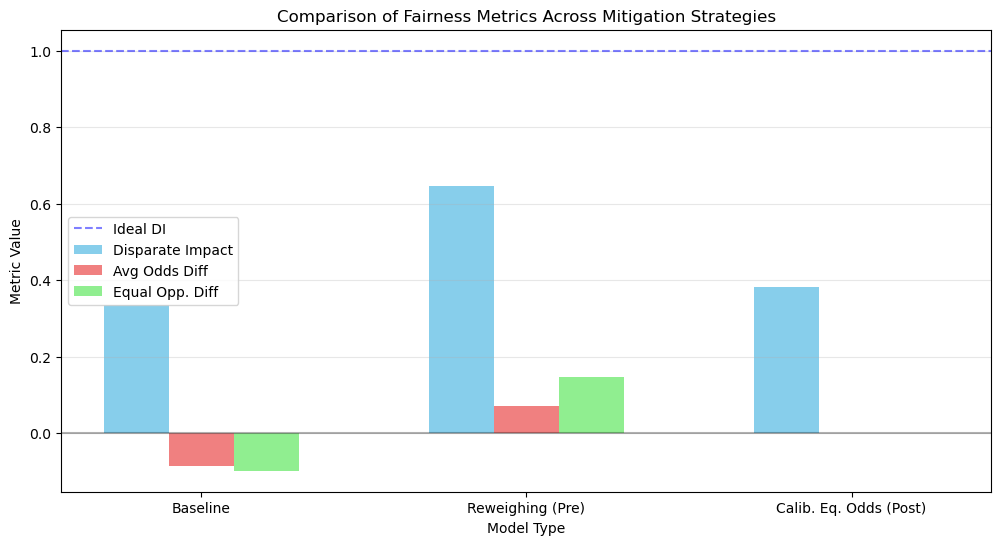

In [116]:
# Visualize the comparison.

# Plot the fairness metrics comparison
fig, ax = plt.subplots(figsize=(12, 6))
x = np.arange(len(comparison_df['Model']))
width = 0.2

ax.bar(x - width, comparison_df['Disparate Impact'], width, label='Disparate Impact', color='skyblue')
ax.bar(x, comparison_df['Avg Odds Difference'], width, label='Avg Odds Diff', color='lightcoral')
ax.bar(x + width, comparison_df['Equal Opp. Difference'], width, label='Equal Opp. Diff', color='lightgreen')

ax.set_xlabel('Model Type')
ax.set_ylabel('Metric Value')
ax.set_title('Comparison of Fairness Metrics Across Mitigation Strategies')
ax.set_xticks(x)
ax.set_xticklabels(comparison_df['Model'])
ax.legend()
ax.axhline(y=0, color='black', linestyle='-', alpha=0.3)
# Add a reference line for ideal Disparate Impact
ax.axhline(y=1, color='blue', linestyle='--', alpha=0.5, label='Ideal DI')
plt.grid(axis='y', alpha=0.3)
plt.legend()
plt.show()